# <u>Count models</u>

Counting is child's play, as easy as 1, 2, 3, right? 

As with most things, the answer's not so simple; some things are easy to count and some things aren't, making some numbers easier to predict than others. What do we do?

1. <font color="darkorchid">**Count what's available**</font> as carefully as possible.
2. Build an appropriate <font color="darkorchid">**probability model**</font> to predict likely outcomes.

To explore this, we'll look at 4 examples of real data:
* cases of chronic medical conditions,
* car crashes in Tennessee,
* births in the United States, and
* coughs in Spain.

We'll see how these relate to 3 fundamental <font color="darkorchid">**count models**</font>:
* binomial models,
* Poisson models, and
* negative binomial models.

Time permitting, we'll talk about using the <font color="darkorchid">**Kolmogorov-Smirnov test**</font> to check a sample against a reference distribution. 

When we meet again, we'll see how to build better predictive models, namely <font color="darkorchid">**regression models for counts**</font> that incorporate predictor variables.


## <u>Imports and settings</u>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom
from scipy.stats import poisson
from scipy.stats import nbinom
from scipy.stats import kstest

In [2]:
sns.set_theme()
plt.rcParams['figure.figsize'] = [15,6]

## <u>Binomial models</u>

### Chronic conditions by age

Here's an important counting problem: given a group of people, how many have a chronic medical condition? Let's see what the 2009 [National Ambulatory Medical Care Survey (NAMCS)](https://www.cdc.gov/nchs/ahcd/index.htm) says:

In [3]:
chronic = pd.read_csv("chronic.csv")
cohorts = pd.read_csv("chronic_cohorts.csv")
cohorts

,Age,Total,Sick,Percentage
0,0,796,21,0.026382
1,1,505,32,0.063366
2,2,320,29,0.090625
3,3,258,37,0.143411
4,4,299,30,0.100334
...,...,...,...,...
96,96,13,12,0.923077
97,97,11,10,0.909091
98,98,6,5,0.833333
99,99,2,1,0.500000


In this dataset, <font color="darkorchid">_Sick_</font> means having at least one of the following conditions:

* arthritis,
* asthma,
* COPD,
* cancer, 
* depression, 
* diabetes, 
* hyperlipidemia,
* hypertension,
* obesity,
* osteoporosis,
* cerebrovascular disease,
* chronic renal failure,  
* congestive heart failure, or 
* ischemic heart disease. 

This is quite a list! The snippet shown corroborates what's expected: older people are more likely to have at least one of these conditions. For example, 30.4% of 25-year-olds have one and 81.43% of the 65-year-olds do:

In [4]:
cohorts[ (cohorts["Age"]==25) | (cohorts["Age"]==65) ]

,Age,Total,Sick,Percentage
25,25,273,83,0.304029
65,65,463,377,0.814255


These percentages are <font color="darkorchid">**empirical probabilities**</font>. Once we have them, what are the chances of having _exactly_ (a) 83 sick people out of 273 25-year-olds and (b) 377 sick people out of 463 65-year-olds? 

### The binomial distribution

If you try something $n$ times with a chance $p$ of <font color="darkorchid">**success**</font> on each <font color="darkorchid">**trial**</font>, the number $Y$ of successes is a <font color="darkorchid">**random variable**</font>: you don't know what the exact outcome will be until it happens, but you know the probability of each possible outcome. In fact, the probability of getting exactly $k$ successes is

$$P( \, Y = k \, ) ~ = ~ \binom{n}{k} \, p^{k} \, (1-p)^{n-k} \ , \quad \text{where} \quad \binom{n}{k} = \frac{ n! }{ k! (n-k)! } \quad .  $$

This is the <font color="darkorchid">**probability mass function (PMF)**</font> for the <font color="darkorchid">**binomial distribution**</font> $B(n,p)$. The mean and variance of a <font color="darkorchid">**binomial random variable**</font> $Y \sim B(n,p)$ are

$$\operatorname{E}\left( \, Y \, \right) ~ = ~ np \quad \text{and} \quad \operatorname{Var}( \, Y \, ) ~ = ~ np(1-p) \ .$$


> **Use the `binom` module from `scipy` (`import`ed above) to work with binomial distributions.**

Based on the NAMCS data, 25-year-olds are like a <font color="darkorchid">**binomial experiment**</font> with $n=273$ and $p=.304029$ ; the chance of observing exactly 83 successes (perverse lingo, I know!) is just over 5% :

In [5]:
p_25 = cohorts["Percentage"][25]
binom.pmf(83,273,p_25)

0.05243020970380286

65-year-olds are like a binomial experiment with 𝑛=463 and 𝑝=.814255 ; the chance of observing exactly 377 successes is just under 5% :

In [6]:
p_65 = cohorts["Percentage"][65]
binom.pmf(377,463,p_65)

0.047625769242453334

Don't be alarmed at these low probabilities &mdash; these are the most likely outcomes!

Text(0.5, 0, '65-year-olds')

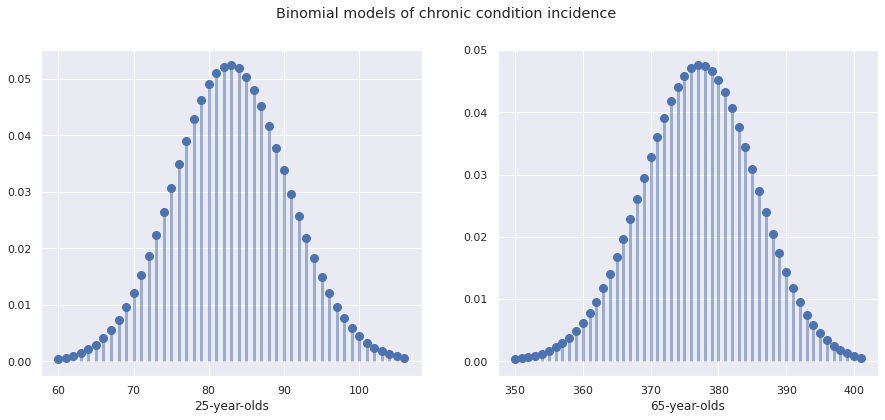

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Binomial models of chronic condition incidence')
x = np.arange(binom.ppf(0.001, 273, p_25), binom.ppf(0.999, 273, p_25))
ax1.plot(x, binom.pmf(x, 273, p_25), 'bo', ms=8)
ax1.vlines(x, 0, binom.pmf(x, 273, p_25), colors='b', lw=3, alpha=0.5)
ax1.set_xlabel('25-year-olds')
x = np.arange(binom.ppf(0.001, 463, p_65), binom.ppf(0.999, 463, p_65))
ax2.plot(x, binom.pmf(x, 463, p_65), 'bo', ms=8)
ax2.vlines(x, 0, binom.pmf(x, 463, p_65), colors='b', lw=3, alpha=0.5)
ax2.set_xlabel('65-year-olds')

It's no accident that these look like normal distributions &mdash; if $n$ is large and/or $p$ is close to $0.5$, $B(n,p)$ is approximately normal with mean $np$ and variance $np(1-p)$ :

$$ B(n,p) \approx N( np, np(1-p) ) \quad \text{for} \quad n \gg 1 \quad \text{or} \quad p \approx 0.5 \ .$$

Turn this around for some quick and dirty calculations. For example, $B(463,.814) \approx N( 377, 70)$, so there will usually be between $377 - 2\sqrt{70} \approx 360 $ and $377 + 2\sqrt{70} \approx 394$ successes, as you can easily check above!

Things are different if $n$ is small and/or $p$ is far from $0.5$. No worries, though &mdash; `binom.pmf` works just fine.

### Binomial logistic regression 

Instead of working separately with each age group &mdash; i.e., each <font color="firebrick">**covariate class**</font> &mdash; we should really construct a <font color="firebrick">**binomial logistic regression model**</font> to consolidate the age group percentages efficiently.

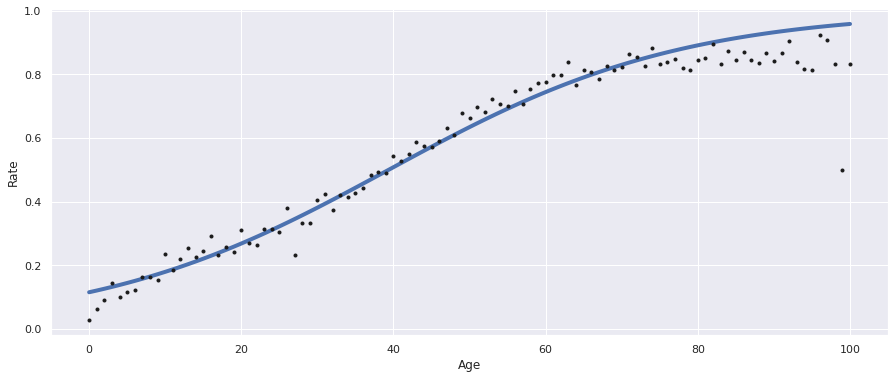

In [8]:
sns.regplot(data=chronic,x="Age", y="Condition",logistic=True, scatter=False,ci=None, line_kws={"lw":"4"})
plt.xlim(-5,105)
plt.ylabel("Rate")
plt.plot( cohorts["Age"], cohorts["Percentage"],'.k');

This particular logistic model, plotted in blue, is <font color="firebrick">**simple**</font> &mdash; it involves only one predictor : 

$$\log{ \left( \text{Odds of a condition} \right) } ~ = ~ -2.04 + .052*\text{Age} \ . $$ 

This model is really a family of binomial distributions, one for each covariate class; each probability is directly related to `Age`.

## <u>Poisson models</u>

### Monthly car crashes 

Here's a different counting problem: how many traffic accidents are there each month where you live? For my home state of Tennessee, the [Department of Transportation provides the relevant data](https://www.tn.gov/safety/stats/crashdata.html):

In [9]:
crashes = pd.read_csv("TDOT.csv")
crashes

,County,Year,January,February,March,April,May,June,July,August,September,October,November,December
0,Anderson,2010,138,113,169,169,155,152,165,176,178,169,179,152
1,Bedford,2010,71,72,77,70,87,99,90,91,86,118,105,95
2,Benton,2010,21,23,27,32,34,29,16,43,31,50,29,36
3,Bledsoe,2010,5,1,3,3,5,1,7,4,3,6,4,3
4,Blount,2010,126,159,171,145,153,139,201,264,338,267,316,269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1040,Wayne,2020,23,15,19,27,18,22,20,24,23,18,22,19
1041,Weakley,2020,39,35,40,19,28,43,37,47,54,44,33,21
1042,White,2020,30,31,33,21,50,32,36,46,34,29,42,43
1043,Williamson,2020,394,424,270,170,226,304,312,310,293,405,368,377


In [10]:
crashes["County"].nunique()

95

Of these 95 counties, let's check out Meigs County (home of the ghost town [Cute, Tennessee](https://en.wikipedia.org/wiki/Cute,_Tennessee)) :

In [11]:
meigs = crashes[crashes["County"]=="Meigs"]
meigs = meigs.drop("County",1)
meigs = meigs.melt( id_vars="Year", var_name="Month", value_name="Crashes" )
meigs

,Year,Month,Crashes
0,2010,January,11
1,2011,January,13
2,2012,January,12
3,2013,January,10
4,2014,January,16
...,...,...,...
127,2016,December,16
128,2017,December,18
129,2018,December,9
130,2019,December,11


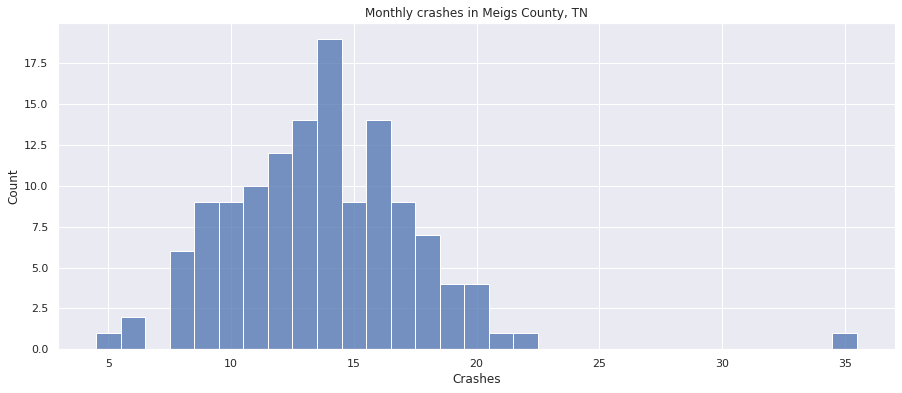

In [12]:
sns.histplot( data=meigs, x="Crashes", discrete=True)
plt.title("Monthly crashes in Meigs County, TN");

### The Poisson distribution

What's the relevant probability distribution? Let's see...

* There are a bunch of encounters between cars every month &mdash; lots of opportunities for accidents to occur. 
* Most encounters don't result in an accident (thank goodness!), but accidents occur at a roughly constant rate per month.

This is a binomial experiment with a large number $n$ of trials, a small chance $p$ of "success" (an accident), and a roughly constant expected number $\lambda = np$ of successes per month, so that $\displaystyle{p = \frac{\lambda}{n}} \ll 1$. Letting $Y$ denote the number of accidents per month,

$$ \begin{align}
P( Y = k ) & ~ = ~ \frac{ n! }{ k! (n-k)! } \left( \frac{\mu}{n} \right)^{k} \left( 1 - \frac{\lambda}{n} \right)^{(n-k)} \\
& ~ = ~ \frac{ n! }{ k! (n-k)! } \left( \frac{\lambda}{n} \right)^{k} \left( 1 - \frac{\lambda}{n} \right)^{n} \left( 1 - \frac{\lambda}{n} \right)^{-k} \\
& ~ \approx ~ \frac{ n! }{ k! (n-k)! } \left( \frac{\lambda}{n} \right)^{k} e^{-\lambda} \\
& ~ = ~ \frac{n (n-1) (n-2) \cdots (n-k+1) }{ n \cdot n \cdot n \cdots n } \ e^{-\lambda} \, \frac{\lambda^k}{ k! } \\
& ~ \approx ~ e^{-\lambda} \, \frac{\lambda^k}{ k! } \ .
\end{align} $$

Lo and behold, that's it! This is the PMF for the <font color="darkorchid">**Poisson distribution**</font> with <font color="darkorchid">**rate**</font> $\lambda$, $\operatorname{Pois}(\lambda)$. The mean and variance of a <font color="darkorchid">**Poisson random variable**</font> $Y \sim \operatorname{Pois}(\lambda)$ are **equal**: 

$$\operatorname{E}\left( \, Y \, \right) ~ = ~ \operatorname{Var}( \, Y \, ) ~ = ~ \lambda \ .$$

> **Use the `poisson` module from `scipy` (`import`ed above) to work with Poisson distributions.**


### Simulating monthly crashes 

Now you'll see why I picked Meigs County:

In [13]:
meigs.agg( Mean = ("Crashes","mean"), Variance = ("Crashes","var") )

,Crashes
Mean,13.712121
Variance,15.198936


How well does the relevant Poisson distribution model crashes in Meigs County? Let's see:

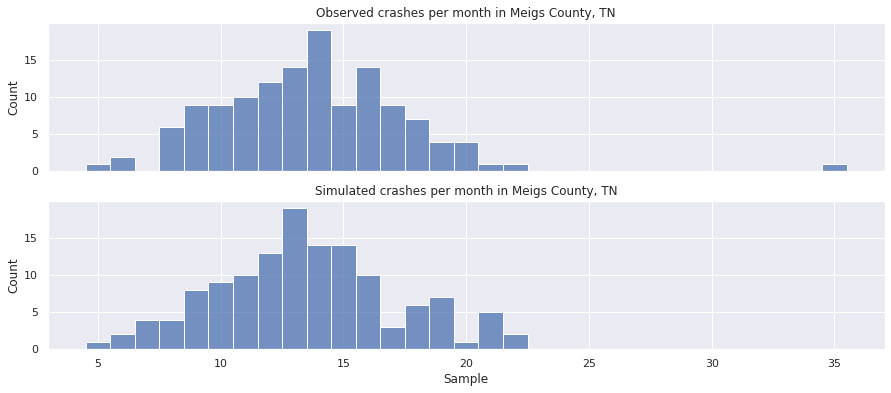

In [14]:
fig, axs = plt.subplots(2, sharex=True)
sns.histplot( data=meigs, x="Crashes", discrete=True, ax=axs[0])
axs[0].set_title("Observed crashes per month in Meigs County, TN")
pois_rv = pd.DataFrame({"Sample" : poisson.rvs( np.mean(meigs["Crashes"]), size=meigs.shape[0])})
sns.histplot(data=pois_rv, x="Sample", discrete=True, ax=axs[1])
axs[1].set_title("Simulated crashes per month in Meigs County, TN");

Not bad! Looks can be deceiving, though &mdash; we'll test things more carefully in a bit.

### Monthly births 

What happens if we count _births_ every month instead of car crashes? Let's look at recent data from the [National Vital Statistics System](https://www.cdc.gov/nchs/nvss/births.htm), downloaded directly from [CDC Wonder](https://wonder.cdc.gov/natality-expanded-current.html):

In [15]:
births = pd.read_csv("births.csv")
births

,county,year,month,births
0,"Baldwin County, AL",2016,January,63
1,"Baldwin County, AL",2016,February,67
2,"Baldwin County, AL",2016,March,69
3,"Baldwin County, AL",2016,April,63
4,"Baldwin County, AL",2016,May,51
...,...,...,...,...
27727,"Winnebago County, WI",2019,August,66
27728,"Winnebago County, WI",2019,September,45
27729,"Winnebago County, WI",2019,October,41
27730,"Winnebago County, WI",2019,November,51


In [16]:
births_by_county = births.groupby("county", as_index=False).agg( Mean = ("births", "mean"), 
                                                                Variance = ("births", "var"), 
                                                                Max = ("births","max") )
births_by_county["Ratio"] = births_by_county["Variance"] / births_by_county["Mean"]
births_by_county = births_by_county[ births_by_county["Max"] < 100 ]
births_by_county = births_by_county.sort_values(by="Ratio", ascending=False)
births_by_county[ abs( births_by_county["Ratio"] - 1 ) < .05 ]

,county,Mean,Variance,Max,Ratio
572,"Yellowstone County, MT",68.666667,71.929078,87,1.047511
293,"Litchfield County, CT",45.125000,47.260638,60,1.047327
20,"Ascension Parish, LA",51.812500,54.155585,69,1.045222
81,"Catawba County, NC",68.666667,71.418440,87,1.040074
48,"Boone County, KY",51.687500,53.070479,72,1.026757
426,"Richland County, OH",36.333333,36.950355,49,1.016982
422,"Randolph County, NC",49.333333,49.631206,65,1.006038
536,"Washington County, MD",57.104167,57.414450,73,1.005434
46,"Blount County, TN",32.250000,32.319149,43,1.002144
486,"St. Lawrence County, NY",27.416667,27.226950,45,0.993080


Oddly enough, the mean and variance for births per month are closest for a county in Tennessee! How well do births in Blount County agree with $\operatorname{Pois}(32.25,32.32)$?

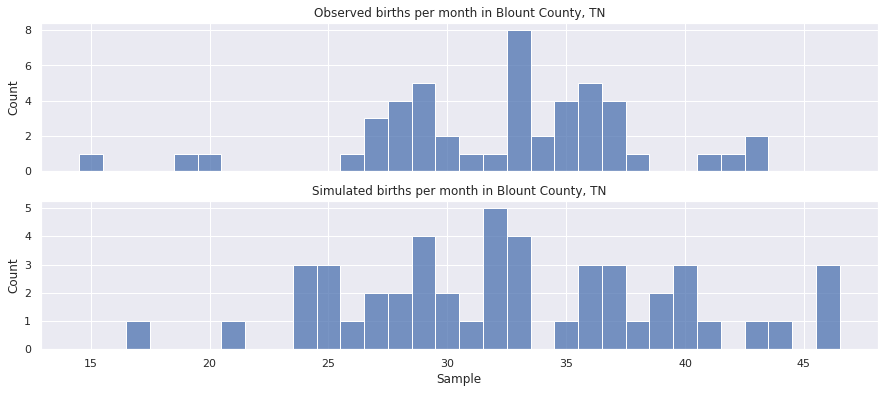

In [17]:
blount = births[ births[ "county"] == "Blount County, TN" ]
fig, axs = plt.subplots(2, sharex=True)
sns.histplot( data=blount, x="births", discrete=True, ax=axs[0])
axs[0].set_title("Observed births per month in Blount County, TN")
pois_rv = pd.DataFrame({"Sample" : poisson.rvs( np.mean(blount["births"]), size=blount.shape[0])})
sns.histplot(data=pois_rv, x="Sample", discrete=True, ax=axs[1])
axs[1].set_title("Simulated births per month in Blount County, TN");

This also looks pretty good! More on this later...

### Poisson regression 

used to determine mean rate per county (crashes per month, births per month)


## <u>Negative binomial models</u>

### Overdispersed monthly births 

The Poisson distribution can clearly be a reasonable model for car crashes or births per month in a given county &mdash; ***if*** the mean and the variance of monthly births are ***equal***! This is definitely not always the case:

In [18]:
births_by_county

,county,Mean,Variance,Max,Ratio
253,"Kanawha County, WV",28.305556,155.989683,52,5.510921
235,"Jackson County, MI",58.645833,157.850621,91,2.691591
423,"Rankin County, MS",54.145833,131.063387,80,2.420563
342,"Monroe County, IN",48.041667,115.317376,72,2.400362
441,"Saline County, AR",53.541667,127.955674,79,2.389834
...,...,...,...,...,...
469,"Sheboygan County, WI",39.833333,36.141844,55,0.907327
556,"Whitfield County, GA",47.708333,42.593972,65,0.892799
226,"Houston County, GA",70.270833,61.903812,89,0.880932
312,"Marathon County, WI",50.479167,42.084663,66,0.833704


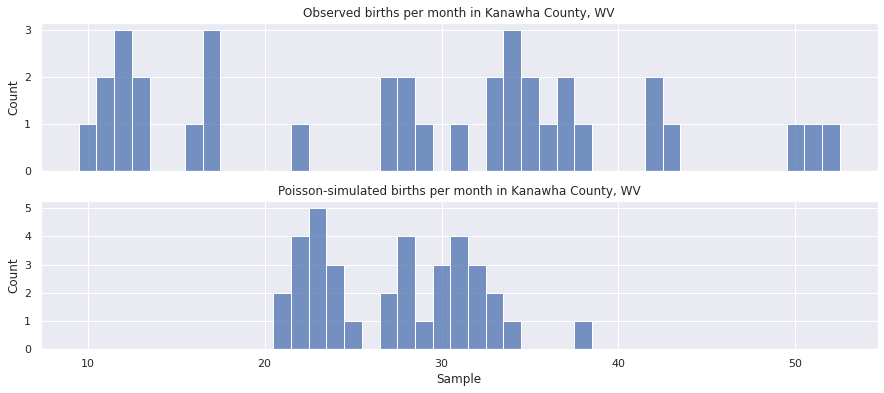

In [19]:
kanawha = births[ births["county"] == "Kanawha County, WV"]
fig, axs = plt.subplots(2, sharex=True)
sns.histplot( data=kanawha, x="births", discrete=True, ax=axs[0])
axs[0].set_title("Observed births per month in Kanawha County, WV")
pois = pd.DataFrame({"Sample" : poisson.rvs( np.mean(kanawha["births"]), size=kanawha.shape[0])})
sns.histplot(data=pois, x="Sample", discrete=True, ax=axs[1])
axs[1].set_title("Poisson-simulated births per month in Kanawha County, WV");

Monthly births in Kanawha County, WV are definitely _not_ Poisson distributed! This is <font color="darkorchid">**overdispersion**</font>: the variance is much larger than the mean. Overdispersion and <font color="darkorchid">**underdispersion**</font> (variance smaller than the mean) are common in count modeling; in either case, Poisson models are _not_ appropriate &mdash; they only apply to counts that are <font color="darkorchid">**equidispersed**</font>.

### Overdispersed monthly car crashes 

***All*** of the counties in the `crashes` dataset exhibit overdispersion, with Meigs County the closest to being equidispersed. At the other extreme, monthly crashes in nearby Hamilton County have a variance that is more than 20 times their mean:

In [20]:
hamilton = crashes[ crashes["County"] == "Hamilton" ]
hamilton = hamilton.drop("County",1)
hamilton = hamilton.melt( id_vars="Year", var_name="Month", value_name="Crashes" )
hamilton.agg( Mean = ("Crashes","mean"), Variance = ("Crashes","var") )

,Crashes
Mean,1047.060606
Variance,22476.347444


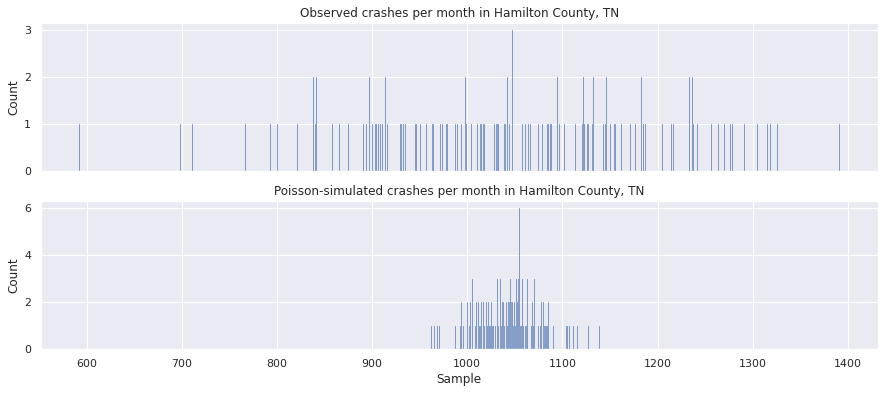

In [21]:
fig, axs = plt.subplots(2, sharex=True)
sns.histplot( data=hamilton, x="Crashes", discrete=True, ax=axs[0])
axs[0].set_title("Observed crashes per month in Hamilton County, TN")
pois = pd.DataFrame({"Sample" : poisson.rvs( np.mean(hamilton["Crashes"]), size=hamilton.shape[0])})
sns.histplot(data=pois, x="Sample", discrete=True, ax=axs[1])
axs[1].set_title("Poisson-simulated crashes per month in Hamilton County, TN");

Terrible!! Never use a Poisson model when there's significant overdispersion!

### Coughs per hour 

The DataFrames `crashes` and `births` share 2 features: counts are recorded _per month_, and _there are no zero counts_ for any month. Of course, there's nothing special about working with months, and there can be plenty of zeroes in some datasets. When monitoring a person's coughs, for example, it's natural to record coughs _per hour_, yielding lots of zeroes. Here are coughs recorded per hour by the [Hyfe cough monitoring app](https://www.hyfeapp.com/) for a person in Spain: 

In [27]:
cougher1 = pd.read_csv("cougher1.csv")
cougher1["datetime"] = pd.to_datetime( cougher1["datetime"] )
cougher1

,datetime,coughs
0,2020-11-06 01:00:00,0
1,2020-11-06 02:00:00,0
2,2020-11-06 03:00:00,0
3,2020-11-06 04:00:00,0
4,2020-11-06 05:00:00,0
...,...,...
7076,2021-08-27 22:00:00,0
7077,2021-08-27 23:00:00,0
7078,2021-08-28 00:00:00,0
7079,2021-08-28 01:00:00,0


Despite what's shown for these 10 hours, this person coughed quite a bit:

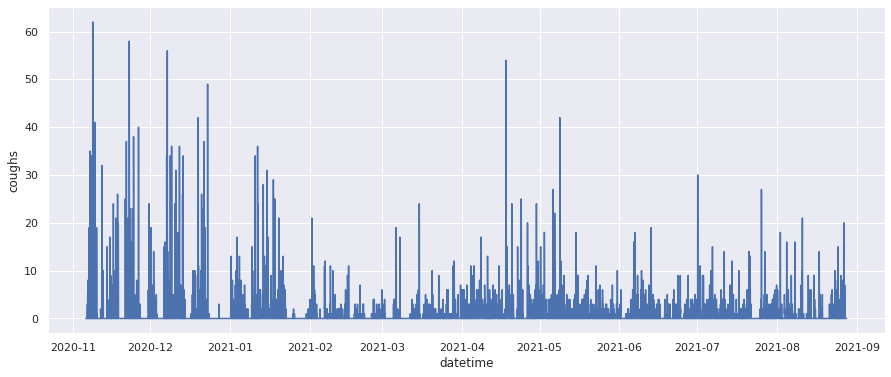

In [29]:
sns.lineplot(data=cougher1, x="datetime", y="coughs");

Even so, there were way more hours with 0 or just a few coughs:

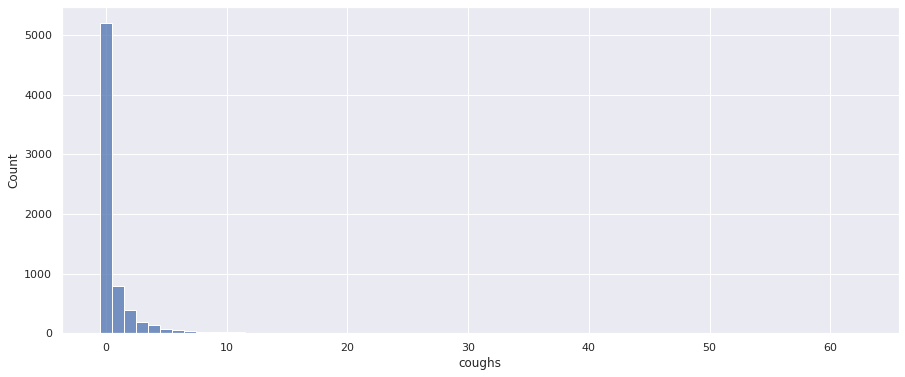

In [32]:
sns.histplot(data=cougher1, x="coughs", discrete=True);

There's clearly some overdispersion here, as we can easily check:

In [69]:
cougher1.agg( Mean = ("coughs","mean"), Variance = ("coughs","var") )

,coughs
Mean,0.99195
Variance,12.03341


This is pretty typical for coughing &mdash; here's another Hyfe user from Spain:

In [42]:
cougher3 = pd.read_csv("cougher3.csv")
cougher3["datetime"] = pd.to_datetime( cougher3["datetime"] )
cougher3

,datetime,coughs
0,2020-11-14 01:00:00,0
1,2020-11-14 02:00:00,0
2,2020-11-14 03:00:00,0
3,2020-11-14 04:00:00,0
4,2020-11-14 05:00:00,0
...,...,...
2012,2021-02-05 21:00:00,0
2013,2021-02-05 22:00:00,0
2014,2021-02-05 23:00:00,0
2015,2021-02-06 00:00:00,0


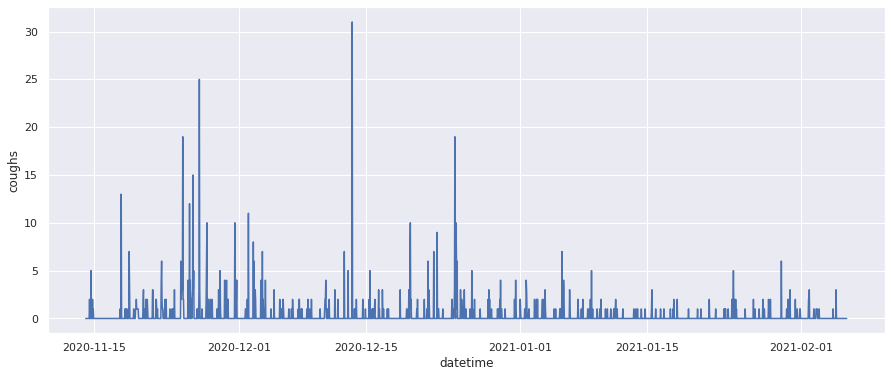

In [43]:
sns.lineplot(data=cougher3, x="datetime", y="coughs");

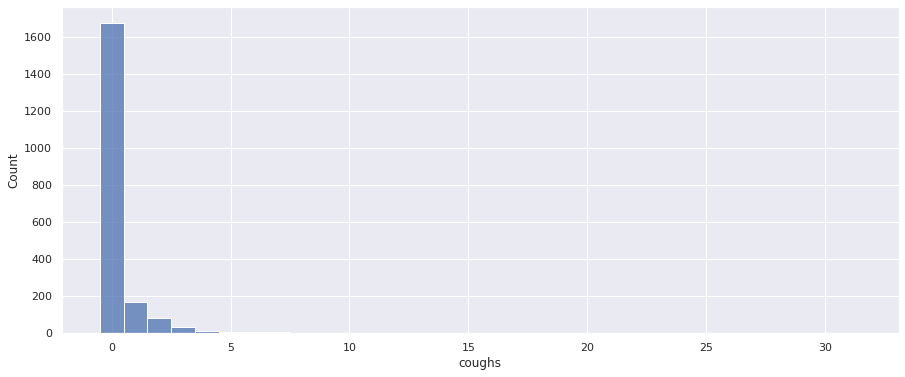

In [44]:
sns.histplot(data=cougher3, x="coughs", discrete=True);

In [45]:
cougher3.agg( Mean = ("coughs","mean"), Variance = ("coughs","var"))

,coughs
Mean,0.411502
Variance,2.487328


### The negative binomial distribution

The Poisson distribution doesn't apply to overdispersed counts, so what distribution does? The go-to option in many cases is the <font color="darkorchid">**negative binomial distribution**</font>, whose PMF has various forms. The form implemented by `scipy.nbinom` is 

$$ P( Y = k ) = \binom{ k+n-1 }{ n-1 } p^{n} \left( 1 - p \right)^{k} \ , \quad k = 0, 1, 2, \ldots \ , $$

reminiscent of the binomial distribution; this is the probability of needing $k+n$ trials to observe $n$ successes when the chance of success per trial is $p$. The mean and variance of $Y \sim \operatorname{NB}(n,p))$ are 

$$\operatorname{E}\left( \, Y \, \right) ~ = ~ \frac{n}{p} \quad \text{and} \quad \operatorname{Var}( \, Y \, ) ~ = ~ \frac{n(1-p)}{p^2} \ .$$


For count models, different parameterizations are common and more practical. Let $\mu$ denote the average of $Y \sim \operatorname{NB}(n,p))$, let $\sigma^2$ denote its variance, and define the <font color="darkorchid">**dispersion parameter**</font> $\alpha$ by

$$ \operatorname{Var}( \, Y \, ) ~ = ~ \mu + \alpha \mu^2 \ . $$

Given the values of 2 of these parameters, relate them to $n$ and $p$:

$$ p ~ = ~ \frac{1}{2 + \alpha \mu} \quad \text{and} \quad n ~ = ~ \frac{\mu}{2 + \alpha \mu} \quad ; \quad p ~ = ~ \frac{\mu}{\mu + \sigma^2} \quad \text{and} \quad n ~ = ~ \frac{\mu^2}{\mu + \sigma^2} \ .$$

You can then translate between the versions, $\operatorname{NB}(n,p))$, $\operatorname{NB}(\mu,\sigma^2))$ and $\operatorname{NB}(\mu,\alpha))$, as needed &mdash; just be aware that other people use $\displaystyle{\frac{1}{\alpha}}$ as the dispersion parameter, and other relationships between it and the variance are possible!

> **Use the `nbinom` module from `scipy` (`import`ed above) to work with negative binomial distributions. Take care when translating parameters!**

### Simulating monthly births

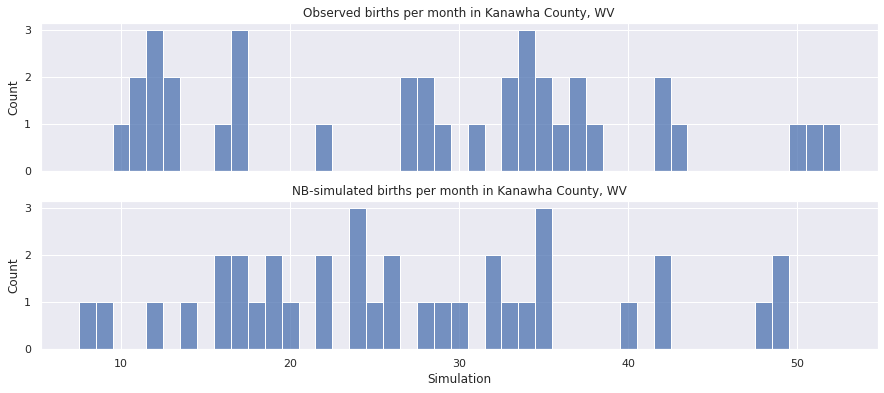

In [74]:
mu = np.mean( kanawha["births"] )
var = np.var( kanawha["births"] )
n = mu**2 / (mu + var )
p = mu / ( mu + var )
fig, axs = plt.subplots(2, sharex=True)
sns.histplot( data=kanawha, x="births", discrete=True, ax=axs[0])
axs[0].set_title("Observed births per month in Kanawha County, WV")
NB = pd.DataFrame({"Simulation" : nbinom.rvs( n, p, size=kanawha.shape[0])})
sns.histplot(data=NB, x="Simulation", discrete=True, ax=axs[1])
axs[1].set_title("NB-simulated births per month in Kanawha County, WV");

### Simulating monthly crashes

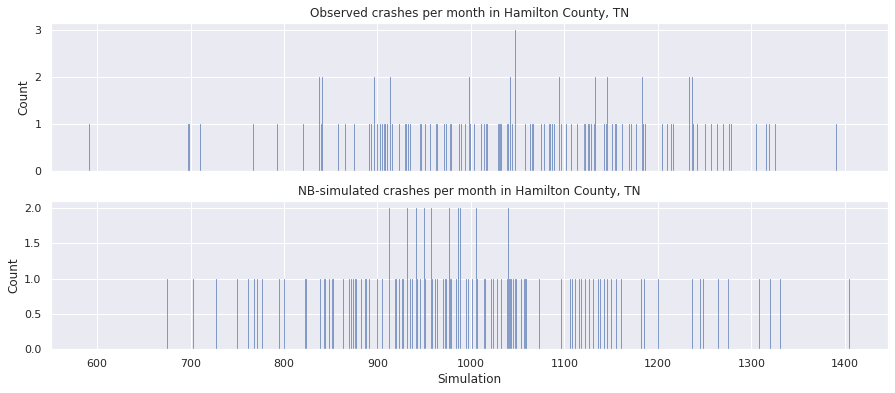

In [76]:
mu = np.mean( hamilton["Crashes"] )
var = np.var( hamilton["Crashes"] )
n = mu**2 / (mu + var )
p = mu / ( mu + var )
fig, axs = plt.subplots(2, sharex=True)
sns.histplot( data=hamilton, x="Crashes", discrete=True, ax=axs[0])
axs[0].set_title("Observed crashes per month in Hamilton County, TN")
NB = pd.DataFrame({"Simulation" : nbinom.rvs( n, p, size=hamilton.shape[0])})
sns.histplot(data=NB, x="Simulation", discrete=True, ax=axs[1])
axs[1].set_title("NB-simulated crashes per month in Hamilton County, TN");

### Simulating coughs per hour

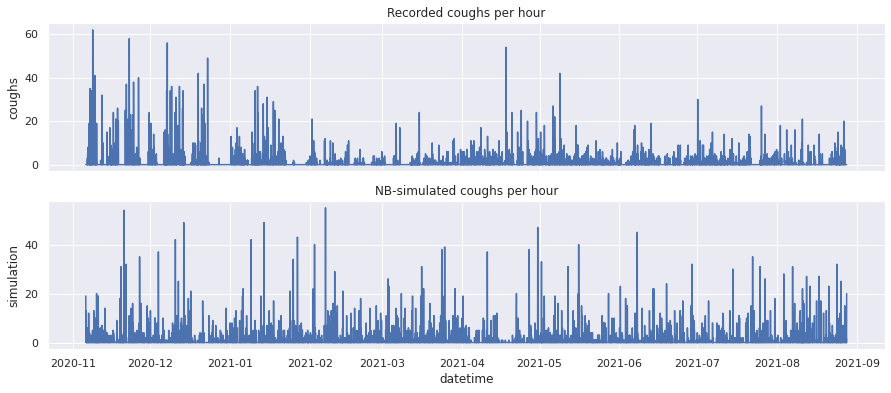

In [66]:
mu = np.mean( cougher1["coughs"] )
var = np.var( cougher1["coughs"] )
n = mu**2 / (mu + var )
p = mu / ( mu + var )
cougher1["simulation"] = nbinom.rvs(n, p, size=cougher1.shape[0])
fig, axs = plt.subplots(2, sharex=True)
sns.lineplot( data=cougher1, x="datetime", y="coughs", ax=axs[0])
axs[0].set_title("Recorded coughs per hour")
sns.lineplot(data=cougher1, x="datetime", y="simulation", ax=axs[1])
axs[1].set_title("NB-simulated coughs per hour");

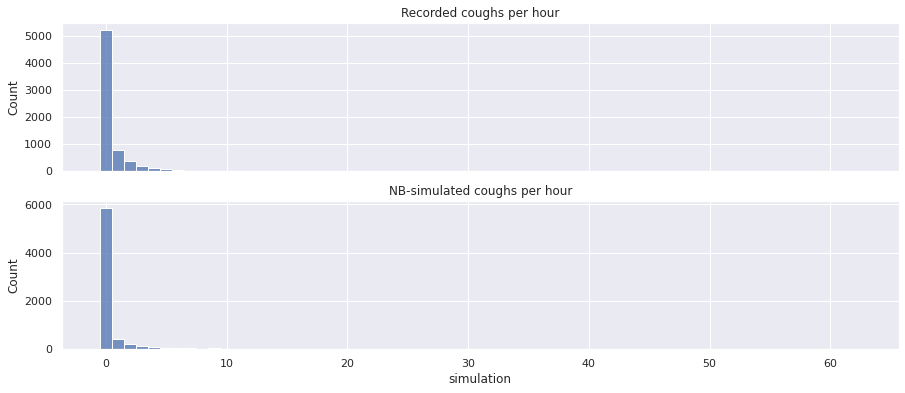

In [65]:
fig, axs = plt.subplots(2, sharex=True)
sns.histplot( data=cougher1, x="coughs", discrete=True, ax=axs[0])
axs[0].set_title("Recorded coughs per hour")
sns.histplot(data=cougher1, x="simulation", discrete=True, ax=axs[1])
axs[1].set_title("NB-simulated coughs per hour");

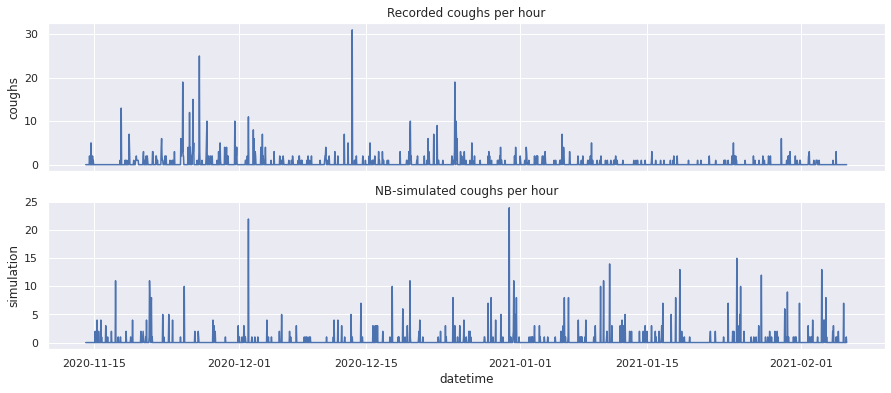

In [67]:
mu = np.mean( cougher3["coughs"] )
var = np.var( cougher3["coughs"] )
n = mu**2 / (mu + var )
p = mu / ( mu + var )
cougher3["simulation"] = nbinom.rvs(n, p, size=cougher3.shape[0])
fig, axs = plt.subplots(2, sharex=True)
sns.lineplot( data=cougher3, x="datetime", y="coughs", ax=axs[0])
axs[0].set_title("Recorded coughs per hour")
sns.lineplot(data=cougher3, x="datetime", y="simulation", ax=axs[1])
axs[1].set_title("NB-simulated coughs per hour");

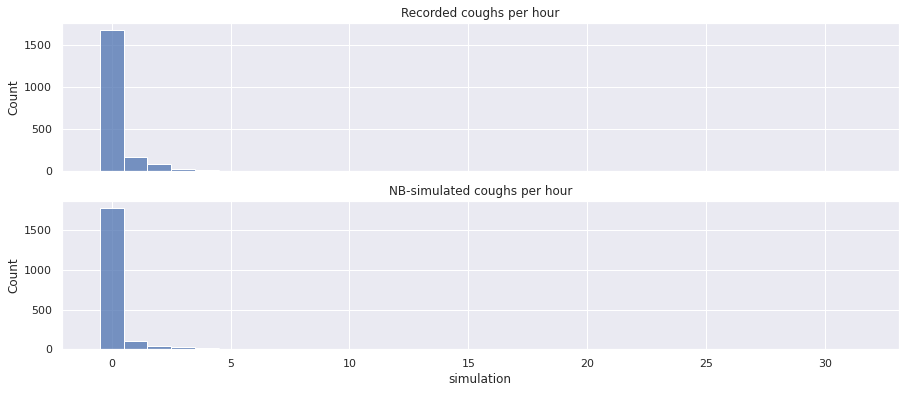

In [68]:
fig, axs = plt.subplots(2, sharex=True)
sns.histplot( data=cougher3, x="coughs", discrete=True, ax=axs[0])
axs[0].set_title("Recorded coughs per hour")
sns.histplot(data=cougher3, x="simulation", discrete=True, ax=axs[1])
axs[1].set_title("NB-simulated coughs per hour");

### Negative binomial regression 

used to determine mean rates 

## <u>The Kolmogorov-Smirnov test</u>

### Cumulative distribution functions


### The K-S test

check whether empirical observations fit a proposed probability distribution